In [1]:
# 20-12-2020 Most Extensive Experiment Analysis

In [1]:
# Models used in saved Neural Network
using Knet: Knet, AutoGrad, dir, Data, minibatch, Param, @diff, value, params, grad, progress, progress!, KnetArray
using IterTools
using Base.Iterators
using Knet: Ops20.zeroone
using Printf, Random, Test, Statistics
using Plots; default(fmt=:png)
include("../utils.jl")

# Define Linear Model
struct Linear; w; b; end
Linear(i::Int,o::Int) = Linear(param(o, i), param0(o))
(m::Linear)(x) = m.w * x .+ m.b
(m::Linear)(x, y) = Knet.nll(m(x), y)
(m::Linear)(data::Knet.Data) = mean(m(x, y) for (x, y) in data)

# MLP Layer - f: can be identity, relu etc,  - pdrop: dropout rate
struct MLPLayer; w; b; f; pdrop; end
MLPLayer(i::Int,o::Int,f=relu; pdrop=0) = MLPLayer(param(o, i), param0(o), f, pdrop)
(l::MLPLayer)(x) = l.f.(l.w * dropout(x, l.pdrop) .+ l.b)

# Define convolutional layer:
struct Conv2; w; b; f; is_pool_enabled::Bool; end
Conv2(w1,w2,nx,ny, f=relu; is_pool_enabled=true) = Conv2(param(w1, w2, nx, ny), param0(1, 1, ny, 1), f, is_pool_enabled)
function (c::Conv2)(x) 
    if c.is_pool_enabled
        pool(c.f.(conv4(c.w, x) .+ c.b))
    else
        c.f.(conv4(c.w, x) .+ c.b)
    end
end

# Define dense layer:
struct Dense; w; b; f; p; end
Dense(i::Int,o::Int,f=relu;pdrop=0) = Dense(param(o, i), param0(o), f, pdrop)
Dense(w, b; f=identity, pdrop=0) = Dense(param(w; atype=Knet.atype()), param(b; atype=Knet.atype()), f, pdrop)
(d::Dense)(x) = d.f.(d.w * mat(dropout(x, d.p)) .+ d.b) 

# Define a chain of layers and a loss function:
struct DeeperCutOption
    connect_res3_to_res5::Bool
end

#=
struct Chain
    layers; lambda1; lambda2; loss; deeperCutOption
    Chain(layers...; lambda1=0, lambda2=0, loss=nll, deeperCutOption=nothing) = new(layers, lambda1, lambda2, loss, deeperCutOption)
end

# The prediction and average loss do not change
function (c::Chain)(x)  
    connection_from3_to5 = nothing;
    for l in c.layers    
         x = l(x)
        
        if c.deeperCutOption.connect_res3_to_res5 
            layer_tag = get_object_tag(l)
            if layer_tag == 3 
                connection_from3_to5 = l.conv3_for_deepercut_output(x)
            end
        end
        
        if c.deeperCutOption.connect_res3_to_res5 
            layer_tag = get_object_tag(l)
            if layer_tag == "part_detect_deconv" 
                x = x .+ connection_from3_to5 
            end
        end
         
    end 
    
    x
end

function (c::Chain)(x, y)
    loss = c.loss(c(x), y)
    if training() # Only apply regularization during training, only to weights, not biases.
        c.lambda1 != 0 && (loss += c.lambda1 * sum(sum(abs, l.w) for l in c.layers))
        c.lambda2 != 0 && (loss += c.lambda2 * sum(sum(abs2, l.w) for l in c.layers))
    end
    return loss
end
(c::Chain)(d::Data) = mean(c(x, y) for (x, y) in d)
=#

#=
struct Deconv; w; stride; padding; tag::String; end
Deconv(w1, w2, nx, ny; stride=1, padding=0, atype=Knet.atype(), tag="") = Deconv(param(w1, w2, nx, ny;atype=atype), stride, padding, tag)

(dc::Deconv)(x) = deconv4(dc.w, x; stride=dc.stride, padding=dc.padding)
=#

# This became redundant now
struct ResLayerConv; w; padding; stride; end
# Random init
ResLayerConv(w1, w2, nx, ny; padding=0, stride=1) = ResLayerConv(param(w1, w2, nx, ny), padding, stride)
# Predeterminde weights
ResLayerConv(w; padding=0, stride=1) = ResLayerConv(param(w), padding, stride)
(rl0::ResLayerConv)(x) = conv4(rl0.w, x; padding=rl0.padding, stride=rl0.stride)

struct BatchNormLayer; w; ms; 

    function BatchNormLayer(pre_w, pre_ms)
        res_mean = popfirst!(pre_ms)
        # Trick to arrange variance value for new(er) batchnorm
        res_variance =   popfirst!(pre_ms).^2  .- 1e-5
        ms = bnmoments(mean=res_mean, var=res_variance)
    
        w1 = pre_w[1]
        w2 = pre_w[2]
        w1 = vec(w1)
        w2 = vec(w2)
        w =  vcat(w1, w2)
        param_w = param(w, atype=Knet.atype())
        return new(param_w, ms)
    end

end

function (batch_norm_layer::BatchNormLayer)(x)
    return batchnorm(x, batch_norm_layer.ms, batch_norm_layer.w; eps=1e-5)
end 

# ResNet 50 initial layer
struct ResLayerX1_50;
    batch_layer;
    conv_w;
    conv_b;
    padding;
    stride;
    pool_window_size;
    pool_stride;
    pool_padding;
end

function ResLayerX1_50(w, ms; padding=3, stride=2, pool_window_size=3, pool_stride=2, pool_padding=1)
    bnl = BatchNormLayer(w[3:4], ms)
    return ResLayerX1_50(bnl,
        param(w[1]; atype=Knet.atype()),
        param(w[2]; atype=Knet.atype()),
        padding,
        stride,
        pool_window_size,
        pool_stride,
    pool_padding)
end

function (rlx1_50::ResLayerX1_50)(x)
    o = conv4(rlx1_50.conv_w, x; padding=rlx1_50.padding, stride=rlx1_50.stride) .+ rlx1_50.conv_b
    o = rlx1_50.batch_layer(o)
    o = relu.(o)
    o = pool(o; window=rlx1_50.pool_window_size, stride=rlx1_50.pool_stride, padding=rlx1_50.pool_padding)
    return o
end

# X0
struct ResLayerX0; batch_layer; conv_w; padding; stride; dilation; end
# Predetermined weights
# TODO: should we try to make bnl params??
function ResLayerX0(w, ms; padding=0, stride=1, dilation=1)
    bnl = BatchNormLayer(w[2:3], ms)
    return   ResLayerX0(
        bnl,        
        param(w[1]; atype=Knet.atype()), 
        padding, 
        stride,
        dilation
    )
end

function (rlx0::ResLayerX0)(x) 
   # batchnorm_as_function(rlx0.batch_w, conv4(rlx0.conv_w, x; padding=rlx0.padding, stride=rlx0.stride), rlx0.ms) 
    o = conv4(rlx0.conv_w, x; padding=rlx0.padding, stride=rlx0.stride, dilation=rlx0.dilation)
    o = rlx0.batch_layer(o)
    return o
end

# X1
struct ResLayerX1; x0_layer; is_initial::Bool; end
ResLayerX1(w, ms; padding=0, stride=1, is_initial::Bool=false, dilation=1) = ResLayerX1(ResLayerX0(w, ms; padding=padding, stride=stride, dilation=dilation), is_initial)
function (rlx1::ResLayerX1)(x)
    relu_res = relu.(rlx1.x0_layer(x))
    if rlx1.is_initial
        return pool(relu_res; window=3, stride=2)
    else
        return relu_res
    end
end


# X2
# TODO: can be constructed like Chain
struct ResLayerX2; x1_a_layer; x1_b_layer; x0_c_layer; end
ResLayerX2(w, ms; pads=[0, 1, 0], strides=[1, 1, 1], dilations=[1,1,1]) = ResLayerX2(
    ResLayerX1(w[1:3], ms; padding=pads[1], stride=strides[1], dilation=dilations[1]),
    ResLayerX1(w[4:6], ms; padding=pads[2], stride=strides[2], dilation=dilations[2]),
    ResLayerX0(w[7:9], ms; padding=pads[3], stride=strides[3], dilation=dilations[3])
    )
(rlx2::ResLayerX2)(x) =   rlx2.x0_c_layer(rlx2.x1_b_layer((rlx2.x1_a_layer(x))))


# X3
struct ResLayerX3; x0_a_layer::ResLayerX0; x2_b_layer::ResLayerX2; end
ResLayerX3(w, ms; pads=[0, 0, 1, 0], strides=[2, 2, 1, 1], b_layer_dilations=[1, 1, 1]) = ResLayerX3(
    ResLayerX0(w[1:3], ms; padding=pads[1], stride=strides[1]),
    ResLayerX2(w[4:12], ms; pads=pads[2:4], strides=strides[2:4], dilations=b_layer_dilations)
    )
function (rlx3::ResLayerX3)(x)
    res_a = rlx3.x0_a_layer(x)
    res_b = rlx3.x2_b_layer(x)
    return relu.(res_a .+ res_b)
end


# X4
struct ResLayerX4;  x2_layer; end
ResLayerX4(w, ms; pads=[ 0, 1, 0], strides=[1, 1, 1], dilations=[1,1,1]) = ResLayerX4(
    ResLayerX2(w, ms; pads=pads, strides=strides, dilations=dilations)
    )
(rlx4::ResLayerX4)(x) =   relu.(x .+ rlx4.x2_layer(x))


# X5
#=
struct ResLayerX5;
    x3_layer::ResLayerX3;
    x4_layers; 
    is_next_fc::Bool;
    conv3_for_deepercut_output;
    tag;
end


function ResLayerX5(w, ms; 
        strides=[2, 2, 1, 1],
        is_next_fc::Bool=false, 
        b_layer_dilations=[1, 1, 1],
        b_layer_pads=[0, 1, 0],
        is_conv3_for_deepercut=false,
        tag=nothing
    )
    x3_layer::ResLayerX3 = ResLayerX3(w[1:12], ms; strides=strides)
    x4_layers = []
    for k = 13:9:length(w)
        layer = ResLayerX4(w[k:k + 8], ms; dilations=b_layer_dilations, pads=b_layer_pads)
        push!(x4_layers, layer)
    end
    
    conv3_for_deepercut_output = nothing
    if is_conv3_for_deepercut
            # 14 layer for part detection
        conv3_for_deepercut_output = Conv2(1, 1, 512, global_num_joints, identity; is_pool_enabled=false)
    end
    
    return ResLayerX5(x3_layer, x4_layers, is_next_fc, conv3_for_deepercut_output, tag)
    end 
=#

#=
function (rlx5::ResLayerX5)(x) 
    x = rlx5.x3_layer(x)
    for l in rlx5.x4_layers
        x = l(x)
    end

    if rlx5.is_next_fc
        return pool(x; stride=1, window=7, mode=2)
    else
        return x
    end
    end 
=#

# OLD IMPLEMENTATIONS's 

struct ResLayerX5;
    x3_layer::ResLayerX3;
    x4_layers; 
    is_next_fc::Bool;
end

function (rlx5::ResLayerX5)(x) 
    x = rlx5.x3_layer(x)
    for l in rlx5.x4_layers
        x = l(x)
    end

    if rlx5.is_next_fc
        return pool(x; stride=1, window=7, mode=2)
    else
        return x
    end
    end 

function ResLayerX5(w, ms; 
        strides=[2, 2, 1, 1],
        is_next_fc::Bool=false, 
        b_layer_dilations=[1, 1, 1],
        b_layer_pads=[0, 1, 0]
    )
    x3_layer::ResLayerX3 = ResLayerX3(w[1:12], ms; strides=strides)
    x4_layers = []
    for k = 13:9:length(w)
        layer = ResLayerX4(w[k:k + 8], ms; dilations=b_layer_dilations, pads=b_layer_pads)
        push!(x4_layers, layer)
    end
    return ResLayerX5(x3_layer, x4_layers, is_next_fc)
end 

struct Deconv; w; stride; padding; end
Deconv(w1, w2, nx, ny; stride=1, padding=0, atype=Knet.atype()) = Deconv(param(w1, w2, nx, ny;atype=atype), stride, padding)
(dc::Deconv)(x) = deconv4(dc.w, x; stride=dc.stride, padding=dc.padding)

struct Chain
    layers; lambda1; lambda2; loss;
    Chain(layers...; lambda1=0, lambda2=0, loss=nll) = new(layers, lambda1, lambda2, loss)
end

# The prediction and average loss do not change
function (c::Chain)(x)  
    for l in c.layers    
         x = l(x)     
    end 
    x
end

function (c::Chain)(x, y)
    loss = c.loss(c(x), y)
    if training() # Only apply regularization during training, only to weights, not biases.
        c.lambda1 != 0 && (loss += c.lambda1 * sum(sum(abs, l.w) for l in c.layers))
        c.lambda2 != 0 && (loss += c.lambda2 * sum(sum(abs2, l.w) for l in c.layers))
    end
    return loss
end
(c::Chain)(d::Data) = mean(c(x, y) for (x, y) in d)

In [2]:
include("../training.jl")
include("../plots.jl")
include("../helper.jl")
include("accuracy.jl")
include("loss.jl")
include("mpii.annotation.parser.jl")

┌ Info: Precompiling Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
└ @ Base loading.jl:1278


compute_scmap_weights (generic function with 1 method)

In [4]:
loaded_batches = Knet.load("20-12-2020-24kimage-batches.jld2", "24k-image-batches")
dtrn, dval = loaded_batches
dtrn_x1, dtrn_y1 = first(dtrn)
dval_x1, dval_y1 = first(dval)
resnet_with_deconv = Knet.load(
    "20-+5ep-12-2020-24kimage-resnet-50.jld2", "resnet_with_deconv"
);

In [5]:
wrong_scs_gt = []
wrong_scs_pred = []
wrong_scs_pred_initial = []
wrong_scs_cache= [wrong_scs_gt, wrong_scs_pred, wrong_scs_pred_initial];

In [6]:
modelized_naive_pck_sigm_with_wrong_cache(resnet_with_deconv, dval, wrong_scs_cache)

0.38374255952380953

In [155]:
modelized_naive_pck_sigm(resnet_with_deconv, dtrn)

0.3845815307437407

In [7]:
wrong_scs_gt;

In [8]:
wrong_idx = 136

136

In [9]:
# 43008 Total number of Joints
test_y = wrong_scs_gt[ wrong_idx ];
test_y_pred = wrong_scs_pred[wrong_idx];
test_y_pred_initial = wrong_scs_pred_initial[wrong_idx];

In [10]:
#findall(x -> x[12, 12] == 1  , wrong_scs_gt )

In [11]:
maxi = argmax(test_y_pred_initial)
println(maxi)
test_y_pred_initial[maxi]

CartesianIndex(17, 14)


0.3297193f0

In [12]:
findall(x->x==1, test_y)

14-element Array{CartesianIndex{2},1}:
 CartesianIndex(22, 23)
 CartesianIndex(23, 23)
 CartesianIndex(21, 24)
 CartesianIndex(22, 24)
 CartesianIndex(23, 24)
 CartesianIndex(24, 24)
 CartesianIndex(21, 25)
 CartesianIndex(22, 25)
 CartesianIndex(23, 25)
 CartesianIndex(24, 25)
 CartesianIndex(21, 26)
 CartesianIndex(22, 26)
 CartesianIndex(23, 26)
 CartesianIndex(24, 26)

In [13]:
max_gt = argmax(test_y)

CartesianIndex(22, 23)

In [14]:
test_y[max_gt]

1.0f0

,,

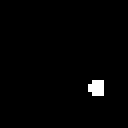
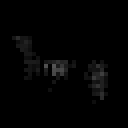
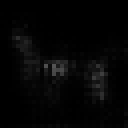

In [15]:
to_be_shown = [colorview(Gray, test_y),
colorview(Gray, test_y_pred),
colorview(Gray, test_y_pred_initial)]

In [16]:
# TODO: Let's find out the PCKh value for the model
# But first we need to figure out matching training data items 

In [17]:
whole_dataset = read_cropped_mpii_annotations(
    ;should_shuffle=false)

Dict{String,Any} with 5 entries:
  "image"     => ["/userfiles/gsoykan20/mpii_human_pose/cropped/im00005_1.png",…
  "annorect"  => Any[Dict{String,Any}("objpos"=>Dict{String,Any}("x"=>158.241,"…
  "size"      => [[3.0 391.0 295.0], [3.0 446.0 368.0], [3.0 252.0 170.0], [3.0…
  "joints"    => Array{Any,2}[[Int32[0 175 261; 1 173 178; … ; 12 187 126; 13 2…
  "is_single" => Any[true, true, true, true, true, true, true, true, true, true…

In [18]:
whole_data_items = get_from_dataset(whole_dataset,
    1,
    whole_dataset_count)

28883-element Array{DataItem,1}:
 DataItem(1, "/userfiles/gsoykan20/mpii_human_pose/cropped/im00005_1.png", [3.0 391.0 295.0], Int32[0 175 261; 1 173 178; … ; 12 187 126; 13 226 72], true, Dict{String,Any}("objpos" => Dict{String,Any}("x" => 158.2412583682625,"y" => 170.13973636471962),"x1" => 180.0879949442771,"y1" => 66.20223204852904,"annopoints" => Dict{String,Any}("point" => Dict{String,Any}("x" => Any[168.83361549602716 193.3284413539829 … 223.78146809630624 220.4713564938798],"id" => Any[6.0 7.0 … 14.0 15.0],"is_visible" => Any[false true … true true],"y" => Any[123.79817393074931 116.51592840541112 … 158.8853569164697 207.2129863118959])),"x2" => 232.38775826261502,"y2" => 131.0804194560875,"scale" => 3.021046176409755))
 DataItem(2, "/userfiles/gsoykan20/mpii_human_pose/cropped/im00005_2.png", [3.0 446.0 368.0], Int32[0 142 227; 1 154 216; … ; 12 156 144; 13 90 138], true, Dict{String,Any}("objpos" => Dict{String,Any}("x" => 188.19023916373374,"y" => 169.60318602347573),"x1" =

In [19]:
whole_data_items = map(d_i -> DataItem(d_i, read_image_h, read_image_w), whole_data_items)

28883-element Array{DataItem,1}:
 DataItem(1, "/userfiles/gsoykan20/mpii_human_pose/cropped/im00005_1.png", [3.0 256.0 256.0], Int32[1 152 171; 2 150 117; … ; 13 162 82; 14 196 47], true, Dict{String,Any}("objpos" => Dict{String,Any}("x" => 158.2412583682625,"y" => 170.13973636471962),"x1" => 156.27974968914174,"y1" => 43.34468354556219,"annopoints" => Dict{String,Any}("point" => Dict{String,Any}("x" => Any[168.83361549602716 193.3284413539829 … 223.78146809630624 220.4713564938798],"id" => Any[6.0 7.0 … 14.0 15.0],"is_visible" => Any[false true … true true],"y" => Any[123.79817393074931 116.51592840541112 … 158.8853569164697 207.2129863118959])),"x2" => 201.6653064705375,"y2" => 85.82247342021313,"scale" => 3.021046176409755))
 DataItem(2, "/userfiles/gsoykan20/mpii_human_pose/cropped/im00005_2.png", [3.0 256.0 256.0], Int32[1 99 130; 2 107 124; … ; 13 109 83; 14 63 79], true, Dict{String,Any}("objpos" => Dict{String,Any}("x" => 188.19023916373374,"y" => 169.60318602347573),"x1" => 68

In [21]:
function load_and_arrange_images(paths)
    loaded_images = load.(paths)
    println("loaded all")
    resized_images = map(
        img -> imresize(img, read_image_w, read_image_h),
        loaded_images)
    println("resized all")
    arranged_img_data = arrange_img_data.(resized_images)
    return arranged_img_data
end 

load_and_arrange_images (generic function with 1 method)

In [22]:
whole_data_items;

In [23]:
whole_arranged_image_data = []

Any[]

In [ ]:
# Could not read all images (28883) so instead read a subset 

In [24]:
for i in 1:100:5000;
    if i == 28801
        current_data_items = whole_data_items[i: end];
    else
        current_data_items = whole_data_items[i: i + 99];
    end
    paths = map(e -> e.path ,current_data_items);
    arranged_img_data = load_and_arrange_images(paths);
    push!(whole_arranged_image_data, arranged_img_data...)
    println(i)
end

loaded all
resized all
1
loaded all
resized all
101
loaded all
resized all
201
loaded all
resized all
301
loaded all
resized all
401
loaded all
resized all
501
loaded all
resized all
601
loaded all
resized all
701
loaded all
resized all
801
loaded all
resized all
901
loaded all
resized all
1001
loaded all
resized all
1101
loaded all
resized all
1201
loaded all
resized all
1301
loaded all
resized all
1401
loaded all
resized all
1501
loaded all
resized all
1601
loaded all
resized all
1701
loaded all
resized all
1801
loaded all
resized all
1901
loaded all
resized all
2001
loaded all
resized all
2101
loaded all
resized all
2201
loaded all
resized all
2301
loaded all
resized all
2401
loaded all
resized all
2501
loaded all
resized all
2601
loaded all
resized all
2701
loaded all
resized all
2801
loaded all
resized all
2901
loaded all
resized all
3001
loaded all
resized all
3101
loaded all
resized all
3201
loaded all
resized all
3301
loaded all
resized all
3401
loaded all
resized all
3501
load

In [25]:
# TODO: let's save read img data after completion

In [35]:
#whole_data_items_with_img_data = pmap(e -> (e, load_and_arrange_image(e.path)) , whole_data_items)

All errors:
ArgumentError: Package ImageIO not found in current path:
- Run `import Pkg; Pkg.add("ImageIO")` to install the ImageIO package.



Errors encountered while loading "/userfiles/gsoykan20/mpii_human_pose/cropped/im19444_1.png".


InterruptException:



Fatal error:


LoadError: ArgumentError: Package ImageIO not found in current path:
- Run `import Pkg; Pkg.add("ImageIO")` to install the ImageIO package.


In [122]:
function find_related_data_items(reshaped_d,
        whole_data_items_with_img_data)
    results = []
    d_size = size(reshaped_d)[4]
    
    collected = collect(enumerate(whole_data_items_with_img_data))
    
    for i in 1:d_size
        d_element = reshaped_d[:, : , :, i:i]
        
        filtered = filter(e -> e[2] == d_element,  collected)
         #check = d_element in whole_data_items_with_img_data      
                
        if !isempty(filtered)
            push!(results, (filtered..., i))
        end
    end
    results
end

find_related_data_items (generic function with 1 method)

In [125]:
reshaped_dtrn = reshape(dtrn.x, dtrn.xsize);
related_data_items_and_data_idxs = find_related_data_items(reshaped_dtrn,
    whole_arranged_image_data)
related_data_idxs = map(x ->  x[2], related_data_items_and_data_idxs);
related_data_item_idxs = map(x ->  x[1][1], related_data_items_and_data_idxs);
related_dtrn_x = reshaped_dtrn[:, : ,:, related_data_idxs];
related_data_items = whole_data_items[related_data_item_idxs];

In [152]:
reshaped_dval = reshape(dval.x, dval.xsize);
related_data_items_and_data_idxs_val = find_related_data_items(
    reshaped_dval,
    whole_arranged_image_data)
related_data_idxs_val = map(x ->  x[2], related_data_items_and_data_idxs_val);
related_data_item_idxs_val = map(x ->  x[1][1], related_data_items_and_data_idxs_val);
related_dval_x = reshaped_dval[:, : ,:, related_data_idxs_val];
related_data_items_val = whole_data_items[related_data_item_idxs_val];

In [130]:
related_dtrn = minibatch(related_dtrn_x,
        32;
        xtype=Knet.atype(), 
        shuffle=false)

134-element Data{KnetArray{Float32,N} where N}

In [153]:
related_dval = minibatch(related_dval_x,
        32;
        xtype=Knet.atype(), 
        shuffle=false)

16-element Data{KnetArray{Float32,N} where N}

In [157]:
for pck in [1.25, 1.5]

acc_trn = modelized_PCKh_sigm(resnet_with_deconv, 
    related_dtrn,
    related_data_items; 
    h_range=pck
)
    
  acc_val =   modelized_PCKh_sigm(resnet_with_deconv, 
    related_dval,
    related_data_items_val; 
    h_range=pck
)
    println("PCKh@ $(pck)")
    println("train accuracy: $(acc_trn)")
    println("validation accuracy: $(acc_val)")    
end


PCKh@ 1.25
train accuracy: 0.689965351812367
validation accuracy: 0.7052176339285714
PCKh@ 1.5
train accuracy: 0.7400719616204693
validation accuracy: 0.7520926339285714
